In [24]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os, sys
import random

!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

from google.colab import drive
drive.mount('/content/drive')

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-yt0yot9k
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-yt0yot9k
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.0-cp36-none-any.whl size=42616 sha256=de5f5bc7e841fedd566332fb55da659b0ab7bb12a7ebc3784d94d8dd9f59ce08
  Stored in directory: /tmp/pip-ephem-wheel-cache-mlzlrzpd/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
Successfully built segmentation-models-pytorch
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class EventDataset(Dataset):
  def __init__(self, pre_dir, post_dir, transform = torchvision.transforms.Compose(
                  [torchvision.transforms.Grayscale(num_output_channels=3),
                   torchvision.transforms.ToTensor()])):
    self.pre_dir = pre_dir
    self.post_dir = post_dir
    self.files_list = [s for s in os.listdir(pre_dir)]
    self.transform = transform

  def change_contrast(self, img, level):
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

  def __len__(self):
    return len(self.files_list)

  def __getitem__(self, idx):
    pre_name = os.path.join(self.pre_dir, self.files_list[idx])
    #pre = self.change_contrast(Image.open(pre_name), 25)
    pre = Image.open(pre_name)
    pre = self.transform(pre)

    post_name = os.path.join(self.post_dir, self.files_list[idx])
    #post = self.change_contrast(Image.open(post_name), 25)
    post = Image.open(post_name)
    post = self.transform(post)
    
    return pre, post, self.files_list[idx]

In [0]:
pre_dir = '/content/drive/My Drive/cs461-final-project/data/disaster_images/pre_event'
post_dir = '/content/drive/My Drive/cs461-final-project/data/disaster_images/post_event'

dataset = EventDataset(pre_dir, post_dir)
data_loader = DataLoader(dataset, batch_size = 1, shuffle=False, num_workers=0)

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#model_path = '/content/drive/My Drive/best_model.pth'
#model_path = '/content/drive/My Drive/best_model_full.pth'
model_path = '/content/drive/My Drive/best_model_unet.pth'
#model_path = '/content/drive/My Drive/cs461-final-project/fcn.pt'
model = torch.load(model_path)

cuda:0


1444
1868.0 1593.0
2031101_13
1.0


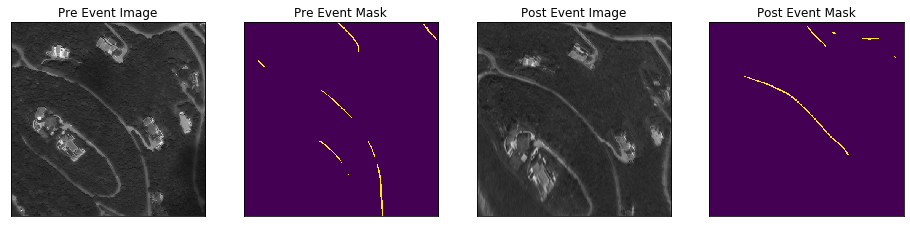

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_13_pre.jpg
3424.0 1368.0
2031101_10265
1.0


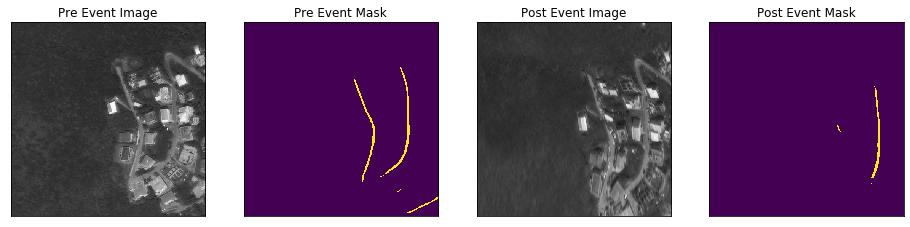

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_10265_pre.jpg
1089.0 851.0
2031101_9247
0.9254902


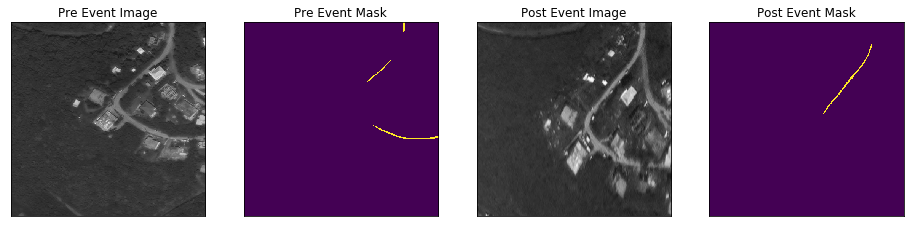

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_9247_pre.jpg
3576.0 2989.0
2031101_10788
1.0


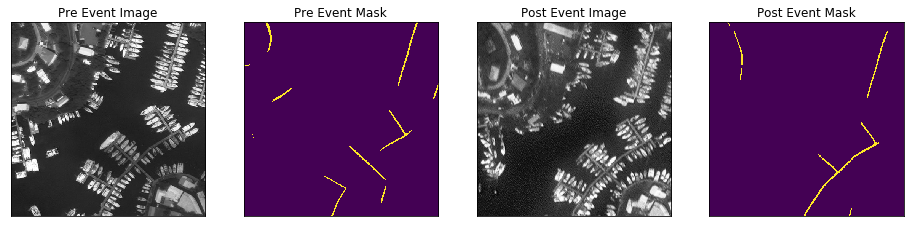

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_10788_pre.jpg
5838.0 1155.0
2031101_8733
1.0


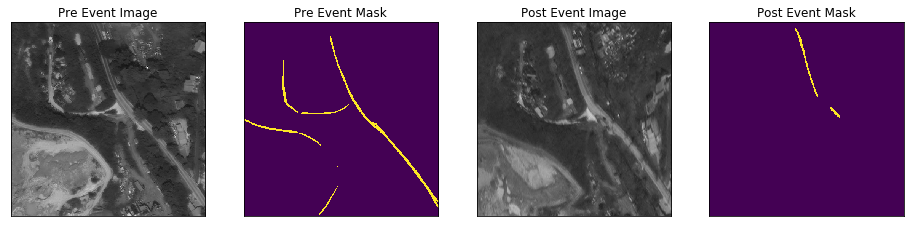

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_8733_pre.jpg
2408.0 863.0
2031101_11281
1.0


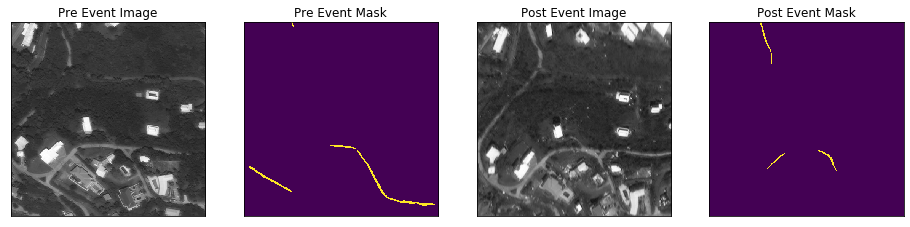

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_11281_pre.jpg
1042.0 964.0
2031101_11300
1.0


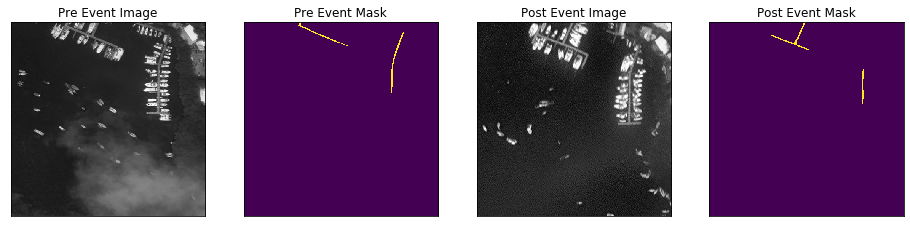

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_11300_pre.jpg
998.0 1346.0
2031101_10778
1.0


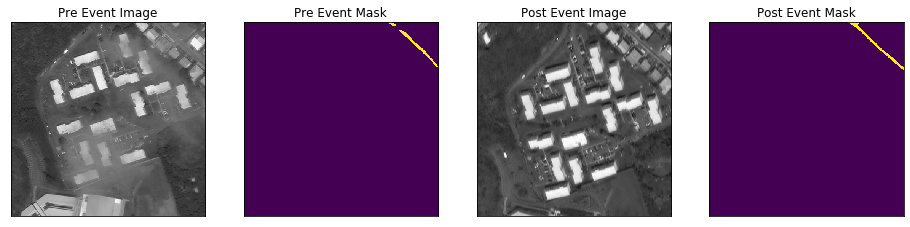

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_10778_pre.jpg
1042.0 964.0
2031101_11300
1.0


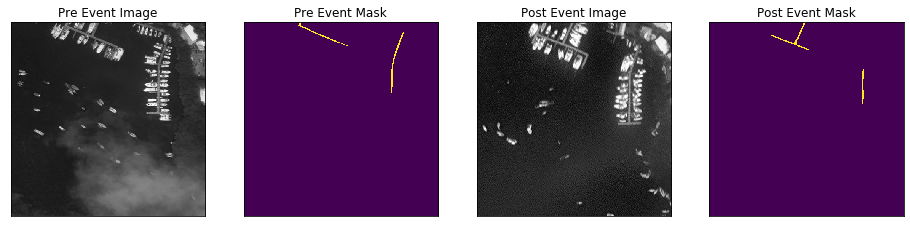

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_11300_pre.jpg
11409.0 1999.0
2031101_7183
1.0


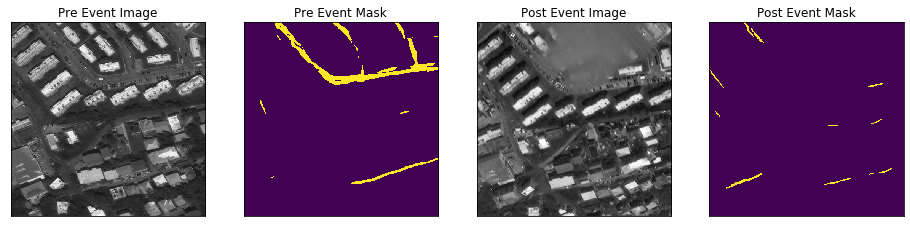

/content/drive/My Drive/cs461-final-project/predictions_unet/2031101_7183_pre.jpg


In [30]:
print(len(dataset))
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

#for i in range(10):
i = 0
while i in range(10):

  n = np.random.choice(len(dataset))
  pre, post, name = dataset[n]
  pre = np.array(pre, dtype = np.float32)
  post = np.array(post, dtype = np.float32)

  pre_tensor = torch.from_numpy(pre).to(device).unsqueeze(0)
  post_tensor = torch.from_numpy(post).to(device).unsqueeze(0)
  pre_mask = model.predict(pre_tensor)
  post_mask = model.predict(post_tensor)
  pre_mask = pre_mask.squeeze().cpu().numpy().round()
  post_mask = post_mask.squeeze().cpu().numpy().round()

  pre_sum = np.sum(pre_mask)
  post_sum = np.sum(post_mask)
  threshold = 800
  if pre_sum < threshold or post_sum < threshold:  
    continue
  print(pre_sum, post_sum)
  print(name[:-4])

  pre = np.transpose(pre, (1, 2, 0))
  post = np.transpose(post, (1, 2, 0))
  #np.set_printoptions(threshold=sys.maxsize)
  #print(np.max(pre))

  visualize(
        pre_event_image= pre,
        pre_event_mask = pre_mask, 
        post_event_image = post, 
        post_event_mask= post_mask
    )
  dest_dir = '/content/drive/My Drive/cs461-final-project/predictions_unet/'
  #dest_dir = '/content/drive/My Drive/cs461-final-project/predictions/'
  print(dest_dir + name[:-4] + '_' + 'pre' + '.jpg')
  cv2.imwrite(dest_dir + name[:-4] + '_' + 'pre' + '.jpg', pre_mask*255)
  cv2.imwrite(dest_dir + name[:-4] + '_' + 'post' + '.jpg', post_mask*255)
  i = i +1